<a href="https://colab.research.google.com/github/rat626/Left-or-Right/blob/main/EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne
import mne;
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 45.4 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using matplotlib as 2D backend.


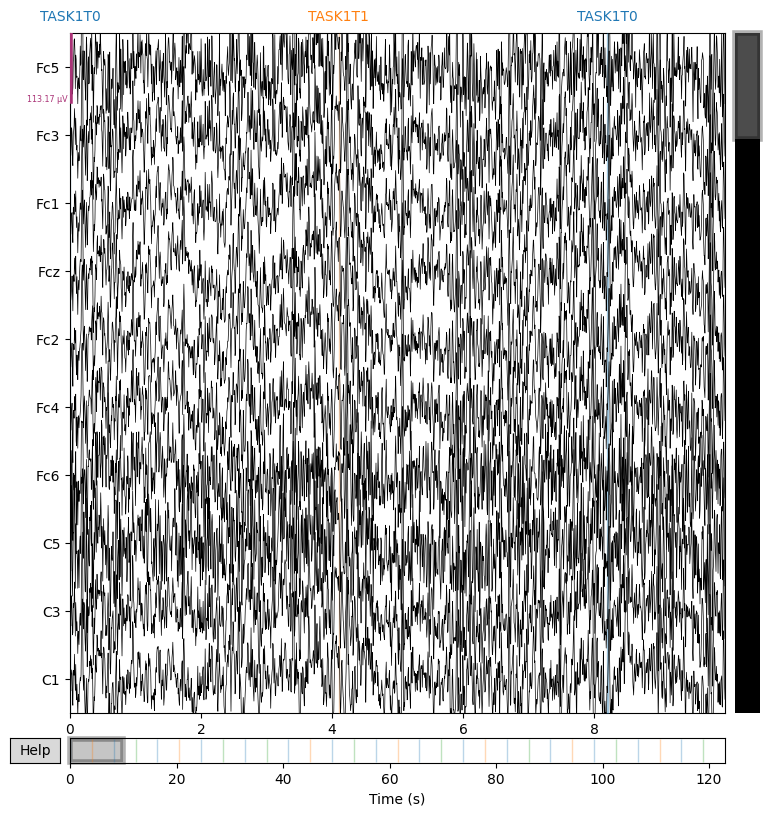

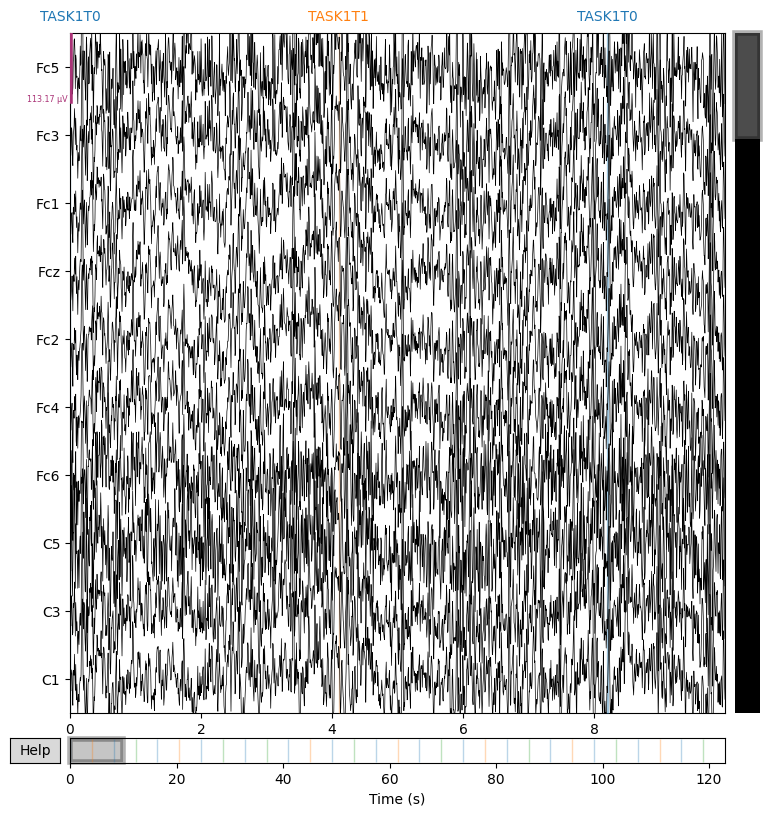

In [ ]:

# Load the EEG data from the .set file
#TASK2T0 - REST
#TASK2T1 - ACTUAL LEFT HAND MOVEMENT
#TASK2T2 - ACTUAL RIGHT HAND MOVEMENT

raw = mne.io.read_raw_eeglab('/content/drive/MyDrive/EEG/Actual Movement/sub-015_task-motion_run-3_eeg.set', preload=True)

# Display basic info
raw.info

# Plot EEG signals
raw.plot(n_channels=10, scalings='auto')



In [ ]:
raw.annotations
#<Annotations | 30 segments: TASK1T0 (1), TASK1T1 (2), TASK2T2 (3)> - each () number represents the event id
#used to create epochs before each eventid


events, event_id = mne.events_from_annotations(raw)
print(event_id)
epochs = mne.Epochs(
    raw,
    events,
    event_id=event_id,
    tmin=-0.2,     # 200ms before the event
    tmax=2.0,      # 2000ms after the event
    baseline=(None, 0),
    preload=True
)



Used Annotations descriptions: [np.str_('TASK1T0'), np.str_('TASK1T1'), np.str_('TASK1T2')]
{np.str_('TASK1T0'): 1, np.str_('TASK1T1'): 2, np.str_('TASK1T2'): 3}
Not setting metadata
30 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 353 original time points ...
1 bad epochs dropped


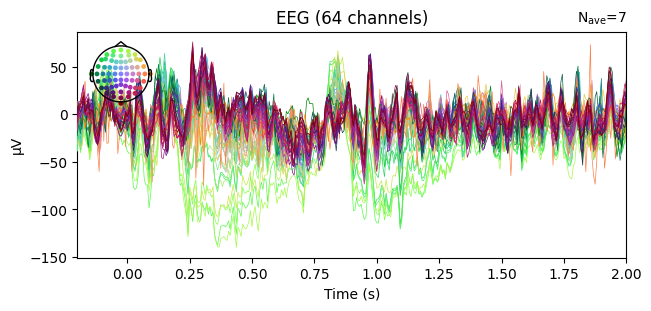

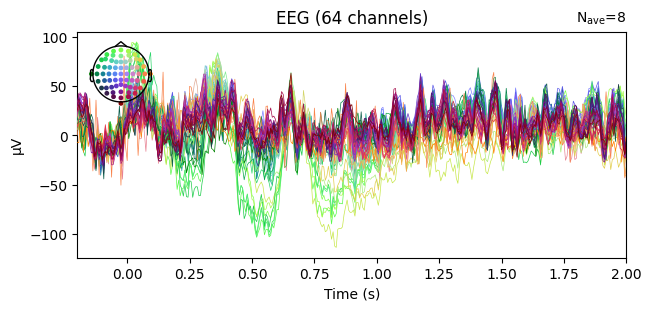

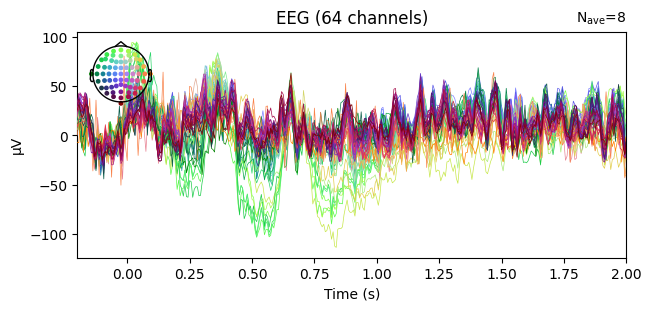

In [ ]:
import matplotlib.pyplot as plt
plt.close('all')

#epochs.plot()
epochs_left = epochs['TASK1T1']
epochs_right = epochs['TASK1T2']
#epochs_rest = epochs['TASK2T0']

epochs_left.average().plot()
epochs_right.average().plot()


Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


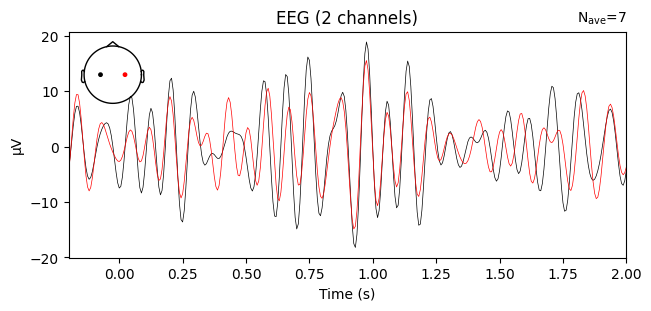

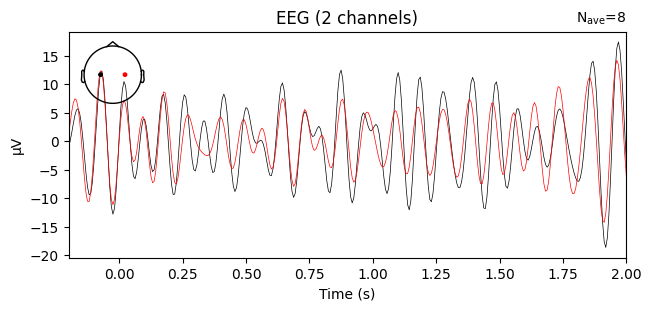

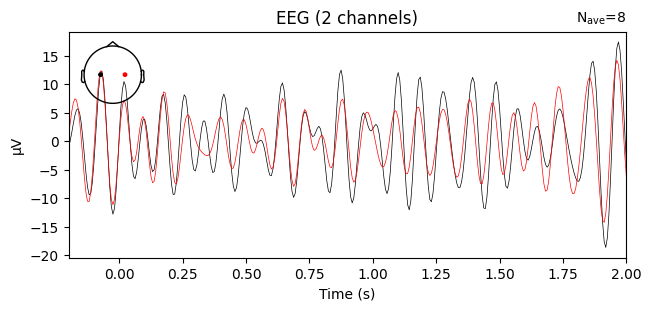

In [ ]:
#extracting epochs with the mu frequency(8-12 Hz)
#There is a mu suppression in the C3 electrode when right hand is moved
#There is mu suppression in C4 when left hand is moved

epochs_filtered = epochs.copy().filter(8., 12.)
epochs_filtered['TASK1T1'].save('epochs_actual_left-epo.fif', overwrite=True)
epochs_filtered['TASK1T2'].save('epochs_actual_right-epo.fif', overwrite=True)

epochs_left = epochs_filtered['TASK1T1']
epochs_right = epochs_filtered['TASK1T2']

# Pick only C3 and C4 electrodes - uses previously made epochs_left and epochs_right and only takes these channels
epochs_left_channelz = epochs_left.copy().pick_channels(['C3', 'C4'])
epochs_right_channelz = epochs_right.copy().pick_channels(['C3', 'C4'])

epochs_left_channelz.average().plot(window_title='Left Hand Actual Movement - C3 & C4 (Mu Band)')
epochs_right_channelz.average().plot(window_title='Right Hand Actual Movement - C3 & C4 (Mu Band)')



In [ ]:
import numpy as np

# Use the filtered data from Task 1 (actual movement)
# These are already filtered to the 8–12 Hz mu band
epochs_left = epochs_filtered['TASK1T1']
epochs_right = epochs_filtered['TASK1T2']

print(len(epochs_left))   #output- 7 - means there are 7 trials of left hand movement
print(len(epochs_right)) #output - 8 - meand there are 8 trials of right hand movement


# Extract data as numpy arrays
# Shape: (n_epochs, n_channels, n_times)
data_left = epochs_left.get_data(picks=['C3', 'C4'])
data_right = epochs_right.get_data(picks=['C3', 'C4'])

# Function to compute average power (mean squared voltage) - creates a function thru def that's used to make X_left and X_right
def compute_band_power(data):
    return np.mean(data ** 2, axis=2)

# Compute power per epoch
X_left = compute_band_power(data_left)
X_right = compute_band_power(data_right)

#X_left and X_right are numpy arrays

#X_left - 7 rows(7 trials) each with mu band power in C3 and C4 for that trial
#X_right - 8 rows(8 trials) each with mu band power in C3 and C4


# Combine features and labels
X = np.vstack([X_left, X_right])
#X is now the combined X_left and X_right array

#Trial 1: C3_mu, C4_mu  ← left-hand trial
#Trial 2: C3_mu, C4_mu  ← left-hand trial
...
#Trial 7: C3_mu, C4_mu  ← left-hand trial
#Trial 8: C3_mu, C4_mu  ← right-hand trial
...
#Trial 15: C3_mu, C4_mu ← right-hand trial



#This is the shape of the array - 14 bc it makes 1 trial per movement - so 7 left 7 right - and then a 15th for the 8th right

y = np.array([0] * len(X_left) + [1] * len(X_right))  # 0 = left hand, 1 = right hand






7
8


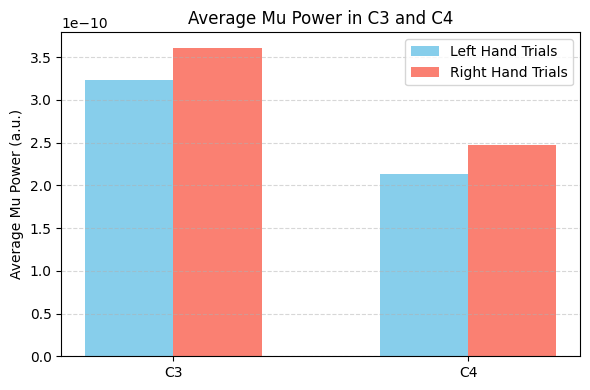

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compute the average mu power across all trials
mean_left = X_left.mean(axis=0)
mean_right = X_right.mean(axis=0)

# Create a bar plot
channels = ['C3', 'C4']  # Since you used these two features
x = np.arange(len(channels))  # x-axis positions

plt.figure(figsize=(6, 4))
plt.bar(x - 0.15, mean_left, width=0.3, label='Left Hand Trials', color='skyblue')
plt.bar(x + 0.15, mean_right, width=0.3, label='Right Hand Trials', color='salmon')
plt.xticks(x, channels)
plt.ylabel('Average Mu Power (a.u.)')
plt.title('Average Mu Power in C3 and C4')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#What is expected: Mu power is lower in C3 when right hand is moved - ACTUAL - NOT TRUE -  C3 IS HIGHER FOR RIGHT HAND?
#What is expected: Mu power is lower in C4 when left hand is moved - ACTUAL - TRUE - C4 IS LOWER FOR LEFT HAND!

In [ ]:
from sklearn.model_selection import train_test_split


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Split the data into train and test sets (optional but good for checking overfitting)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#This makes it so that 75% of the data is used for training, 25% is used for testing

# 2. Create the KNN classifier (try k=3 as a start)
knn = KNeighborsClassifier(n_neighbors=3)

# 3. Train the model
knn.fit(X_train, y_train)

# 4. Predict on the test set
y_pred = knn.predict(X_test)

# 5. Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.25

Confusion Matrix:
 [[0 1]
 [2 1]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      0.33      0.40         3

    accuracy                           0.25         4
   macro avg       0.25      0.17      0.20         4
weighted avg       0.38      0.25      0.30         4



In [ ]:
#knneighbors on just subject 15 did not work well - so now we are condensing all the steps into a pipeline and running a for loop to process subjects 14, 15, and 16

import mne
import numpy as np
import os

def process_subject(filepath, event_id_map={'TASK1T1': 0, 'TASK1T2': 1}):
    raw = mne.io.read_raw_eeglab(filepath, preload=True)

    # Get events and create epochs
    events, event_id = mne.events_from_annotations(raw)
    epochs = mne.Epochs(
        raw,
        events,
        event_id=event_id,
        tmin=-0.2,
        tmax=2.0,
        baseline=(None, 0),
        preload=True
    )

    # Bandpass filter to isolate mu rhythm
    epochs_filtered = epochs.copy().filter(8., 12.)

    # Get data for left and right hand movement (TASK1T1 = left, TASK1T2 = right)
    data_X = []
    data_y = []

    for label, y_val in event_id_map.items():
        if label in epochs_filtered.event_id:
            epochs_task = epochs_filtered[label]
            selected_channels = ['C3', 'C4', 'Po8', 'T8', 'Fc5', 'F7']
            data = epochs_task.get_data(picks=selected_channels)
            power = np.mean(data ** 2, axis=2)
            data_X.append(power)
            data_y.extend([y_val] * len(power))

    # Combine all data for this subject
    if data_X:
        X = np.vstack(data_X)
        y = np.array(data_y)
        return X, y
    else:
        return None, None

In [ ]:
subjects = ['sub-014', 'sub-015', 'sub-016', 'sub-017', 'sub-018']
run = 'task-motion_run-3_eeg.set'
base_path = '/content/drive/MyDrive/EEG/Actual Movement'  # adjust path as needed

X_all = []
y_all = []

for subj in subjects:
    filepath = os.path.join(base_path, f'{subj}_{run}')
    X_subj, y_subj = process_subject(filepath)
    if X_subj is not None:
        X_all.append(X_subj)
        y_all.append(y_subj)

# Final combined training data
X = np.vstack(X_all)
y = np.hstack(y_all)

print("Shape of X:", X.shape)  # Should be (# total trials, 2)
print("Shape of y:", y.shape)  # Should be (# total trials,)

Used Annotations descriptions: [np.str_('TASK1T0'), np.str_('TASK1T1'), np.str_('TASK1T2')]
Not setting metadata
30 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 353 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: [np.str_('TASK1T0'), np.str_('TASK1T1'), np.str_('TASK1T2')]
Not setting metadata
30 matching events f

In [ ]:
from sklearn.model_selection import train_test_split


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Split the data into train and test sets (optional but good for checking overfitting)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#This makes it so that 75% of the data is used for training, 25% is used for testing

# 2. Create the KNN classifier (try k=3 as a start)
knn = KNeighborsClassifier(n_neighbors=9)

# 3. Train the model
knn.fit(X_train, y_train)

# 4. Predict on the test set
y_pred = knn.predict(X_test)

# 5. Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.47368421052631576

Confusion Matrix:
 [[4 7]
 [3 5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.36      0.44        11
           1       0.42      0.62      0.50         8

    accuracy                           0.47        19
   macro avg       0.49      0.49      0.47        19
weighted avg       0.51      0.47      0.47        19



In [ ]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt

# Use K=5 for visualization
k_best = 9
knn = KNeighborsClassifier(n_neighbors=k_best)
knn.fit(X_train, y_train)

# Set up color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ['red', 'blue']

# Create meshgrid
h = .01  # step size in the mesh
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict labels for each point in meshgrid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.7)

# Plot training points
for label in np.unique(y_train):
    plt.scatter(X_train[y_train == label][:, 0],
                X_train[y_train == label][:, 1],
                label=f'Class {label} (Train)',
                edgecolor='k',
                c=cmap_bold[label],
                s=70)

plt.xlabel('C3 Mu Power')
plt.ylabel('C4 Mu Power')
plt.title(f'KNN Decision Boundary (k={k_best})')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


ValueError: X has 2 features, but KNeighborsClassifier is expecting 6 features as input.

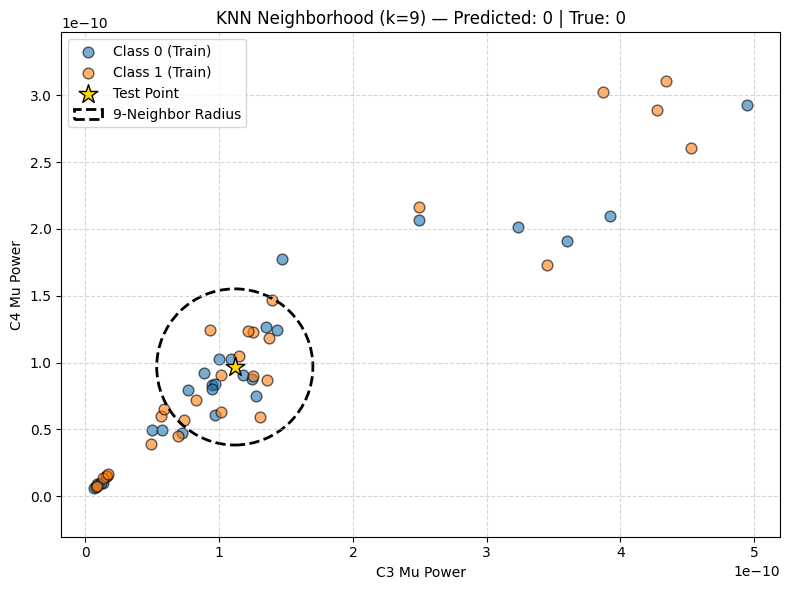

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from matplotlib.patches import Circle

# Fit KNN with k=9
k = 9
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Pick one test point (e.g., the first one)
test_idx = 0
test_point = X_test[test_idx].reshape(1, -1)
true_label = y_test[test_idx]
predicted_label = knn.predict(test_point)[0]

# Get distances and indices of the k neighbors
distances, indices = knn.kneighbors(test_point)

# Get the farthest neighbor distance (for the circle radius)
radius = distances[0].max()

# Plot training data
plt.figure(figsize=(8, 6))
for label in np.unique(y_train):
    subset = X_train[y_train == label]
    plt.scatter(subset[:, 0], subset[:, 1], label=f'Class {label} (Train)',
                alpha=0.6, edgecolor='k', s=60)

# Highlight test point
plt.scatter(test_point[0][0], test_point[0][1],
            color='gold', edgecolor='black', s=200, label='Test Point', marker='*', zorder=5)

# Draw a circle around the k-nearest neighbors
circle = Circle((test_point[0][0], test_point[0][1]), radius=radius,
                edgecolor='black', facecolor='none', linewidth=2, linestyle='--', label=f'{k}-Neighbor Radius')
plt.gca().add_patch(circle)

# Labels & aesthetics
plt.title(f"KNN Neighborhood (k={k}) — Predicted: {predicted_label} | True: {true_label}")
plt.xlabel("C3 Mu Power")
plt.ylabel("C4 Mu Power")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.axis('equal')
plt.tight_layout()
plt.show()


In [ ]:
#plotting graph of how accuracy changes with number of knneighbors

import matplotlib.pyplot as plt
import numpy as np

# Create a bar plot
k_values = [3,5,7,9,11,13]
accuracies = []


for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='navy')
plt.xticks(k_values)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy vs. Number of Neighbors')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 1)
plt.show()

In [ ]:

channels_to_use = ['C3', 'C4', 'Po8', 'T8', 'Fc5', 'F7']

def process_subject(filepath, event_id_map={'TASK2T1': 0, 'TASK2T2': 1}):
    raw = mne.io.read_raw_eeglab(filepath, preload=True)

    # Get events and create epochs
    events, event_id = mne.events_from_annotations(raw)
    epochs = mne.Epochs(
        raw,
        events,
        event_id=event_id,
        tmin=-0.2,
        tmax=2.0,
        baseline=(None, 0),
        preload=True
    )

    # Bandpass filter to isolate mu rhythm
    epochs_filtered = epochs.copy().filter(8., 12.)
    if 'TASK2T1' in epochs_filtered.event_id:
      epochs_filtered['TASK2T1'].save('epochs_imagined_left-epo.fif', overwrite=True)

    if 'TASK2T2' in epochs_filtered.event_id:
      epochs_filtered['TASK2T2'].save('epochs_imagined_right-epo.fif', overwrite=True)



    # Get data for imagined left and right hand movement (TASK2T1 = left, TASK2T2 = right)
    data_X = []
    data_y = []

    for label, y_val in event_id_map.items():
        if label in epochs_filtered.event_id:
            epochs_task = epochs_filtered[label]
            data = epochs_task.get_data(picks=channels_to_use)
            power = np.mean(data ** 2, axis=2)
            data_X.append(power)
            data_y.extend([y_val] * len(power))

    # Combine all data for this subject
    if data_X:
        X = np.vstack(data_X)
        y = np.array(data_y)
        return X, y
    else:
        return None, None



In [ ]:
os.listdir('/content/drive/MyDrive/EEG')

In [ ]:
subjects = ['sub-014', 'sub-015', 'sub-016', 'sub-017', 'sub-018']
run = 'task-motion_run-4_eeg.set'
base_path = '/content/drive/MyDrive/EEG/ImaginedMovement'

X_imagery_all = []
y_imagery_all = []

event_id_map = {'TASK2T1': 0, 'TASK2T2': 1}  # left vs right imagery

for subj in subjects:
    filepath = os.path.join(base_path, f'{subj}_{run}')
    print("Trying:", filepath)
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        continue

    X_subj, y_subj = process_subject(filepath, event_id_map=event_id_map)
    if X_subj is not None:
        X_imagery_all.append(X_subj)
        y_imagery_all.append(y_subj)

# Combine all imagined movement data
X_imagery = np.vstack(X_imagery_all)
y_imagery = np.hstack(y_imagery_all)

print("Imagery X shape:", X_imagery.shape)
print("Imagery y shape:", y_imagery.shape)

Trying: /content/drive/MyDrive/EEG/ImaginedMovement/sub-014_task-motion_run-4_eeg.set
Used Annotations descriptions: [np.str_('TASK2T0'), np.str_('TASK2T1'), np.str_('TASK2T2')]
Not setting metadata
30 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 353 original time points ...
1 bad epochs dropped
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 265 samples (1.656 s)

Overwriting existing file.
Overwriting existing

In [ ]:
# X_imagery and y_imagery should already be extracted from run-4
y_imagery_pred = knn.predict(X_imagery)

# Evaluate performance on imagined movement
print("Accuracy on Imagined Movement:", accuracy_score(y_imagery, y_imagery_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_imagery, y_imagery_pred))
print("\nClassification Report:\n", classification_report(y_imagery, y_imagery_pred))

Accuracy on Imagined Movement: 0.5733333333333334

Confusion Matrix:
 [[11 24]
 [ 8 32]]

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.31      0.41        35
           1       0.57      0.80      0.67        40

    accuracy                           0.57        75
   macro avg       0.58      0.56      0.54        75
weighted avg       0.57      0.57      0.55        75



In [ ]:
from google.colab import files

# Download the saved filtered epochs for left and right hand movement
files.download('epochs_actual_left-epo.fif')
files.download('epochs_actual_right-epo.fif')
files.download('epochs_imagined_left-epo.fif')
files.download('epochs_imagined_right-epo.fif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install -q mne
import mne
import matplotlib.pyplot as plt


# Load actual movement
epochs_actual_left = mne.read_epochs('epochs_actual_left-epo.fif', preload=True)
epochs_actual_right = mne.read_epochs('epochs_actual_right-epo.fif', preload=True)

# Load imagined movement
epochs_imagined_left = mne.read_epochs('epochs_imagined_left-epo.fif', preload=True)
epochs_imagined_right = mne.read_epochs('epochs_imagined_right-epo.fif', preload=True)


# Get evoked responses (average across epochs)
evoked_actual_left = epochs_actual_left.average()
evoked_actual_right = epochs_actual_right.average()
evoked_imagined_left = epochs_imagined_left.average()
evoked_imagined_right = epochs_imagined_right.average()

# Set time point of interest (e.g., ~1s post-stimulus)
time_point = 1.0  # seconds

# Plot all 4 topomaps in a 2x2 grid
# Plot all 4 topomaps in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Actual Movement
evoked_actual_left.plot_topomap(times=time_point, axes=axes[0, 0], show=False, colorbar=False)
axes[0, 0].set_title('Actual Left')

evoked_actual_right.plot_topomap(times=time_point, axes=axes[0, 1], show=False, colorbar=False)
axes[0, 1].set_title('Actual Right')

# Imagined Movement
evoked_imagined_left.plot_topomap(times=time_point, axes=axes[1, 0], show=False, colorbar=False)
axes[1, 0].set_title('Imagined Left')

evoked_imagined_right.plot_topomap(times=time_point, axes=axes[1, 1], show=False, colorbar=False)
axes[1, 1].set_title('Imagined Right')

fig.suptitle('Mu-Band Topomaps 1 second after Event', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
evoked_diff_actual = mne.combine_evoked([evoked_actual_right, evoked_actual_left], weights=[1, -1])
evoked_diff_imag = mne.combine_evoked([evoked_imagined_right, evoked_imagined_left], weights=[1, -1])
# Choose time point (in seconds)
time_point = 1.0

# Plot the difference topomap
evoked_diff_actual.plot_topomap(times=[time_point], cmap='RdBu_r', colorbar = False)
evoked_diff_imag.plot_topomap(times=[time_point],cmap='RdBu_r', colorbar = False)


In [ ]:
import numpy as np

# Load the evoked difference object (you already have this):
# evoked_diff_actual = mne.combine_evoked([evoked_actual_right, evoked_actual_left], weights=[1, -1])
# Or for imagined: evoked_diff_imag

# Get data at your time of interest (e.g., 1.0s)
time_index = evoked_diff_actual.time_as_index(1.0)[0]  # Convert 1.0 sec to index
data_at_time = evoked_diff_actual.data[:, time_index]  # shape = (n_channels,)

# Get channel names
channel_names = evoked_diff_actual.ch_names

# Pair names with their values
channel_diffs = list(zip(channel_names, data_at_time))

# Sort to find max and min
sorted_diffs = sorted(channel_diffs, key=lambda x: x[1], reverse=True)

# Get top 2 and bottom 2
top_2 = sorted_diffs[:2]
bottom_2 = sorted_diffs[-2:]

print("Top 2 electrodes (most positive difference):", top_2)
print("Bottom 2 electrodes (most negative difference):", bottom_2)